# Exploring trends and seasonal changes in data


In this notebook, we identify trends and seasonal patterns in the data using the Python statsmodels library.

### 1. Importing Python libraries

In [1]:
import numpy as np
import pandas as pd
import calendar
from dateutil import tz

import matplotlib.pyplot as plt
import statsmodels as sm
from statsmodels.tsa.stattools import adfuller

#setting plot size
plt.rcParams['figure.figsize'] = [14,8]

### 2. Reading data

In [2]:
file = '../Data/AucklandRainfall1872-1997.csv'
 
rain=pd.read_csv(file, skiprows=3, header=None,
                  names=['Date','rain_value', 'grade', 'interpol_type', 'event_timestamp'],
                  parse_dates=['Date'],
                  index_col='Date')

rain.head(5)

,rain_value,grade,interpol_type,event_timestamp
Date,,,,
1872-01-03,0.00,200,5,NaN
1872-01-04,3.81,200,5,NaN
1872-01-05,2.03,200,5,NaN
1872-01-09,0.00,200,5,NaN
1872-01-10,0.51,200,5,NaN


### 3. Examining the table

We prepare the input table by removing unnecessary columns and resampling the data to monthly and annual mean values.

In [3]:
#Compute ADF p-value
adf = adfuller(rain['rain_value'], autolag='AIC')
print(f'SDF Statistics: {adf[0]}')
print("The p-value for the ADF test is ", adf[1])
print("Critical Values:")
for key,value in adf[4].items():
    print(f'   {key}, {value}')

SDF Statistics: -24.44272586840839
The p-value for the ADF test is  0.0
Critical Values:
   1%, -3.4305568781184475
   5%, -2.861631434707597
   10%, -2.5668186678748155


Since the p-value is less than the significance level of 0.05, we reject the null hypothesis of non-stationarity.

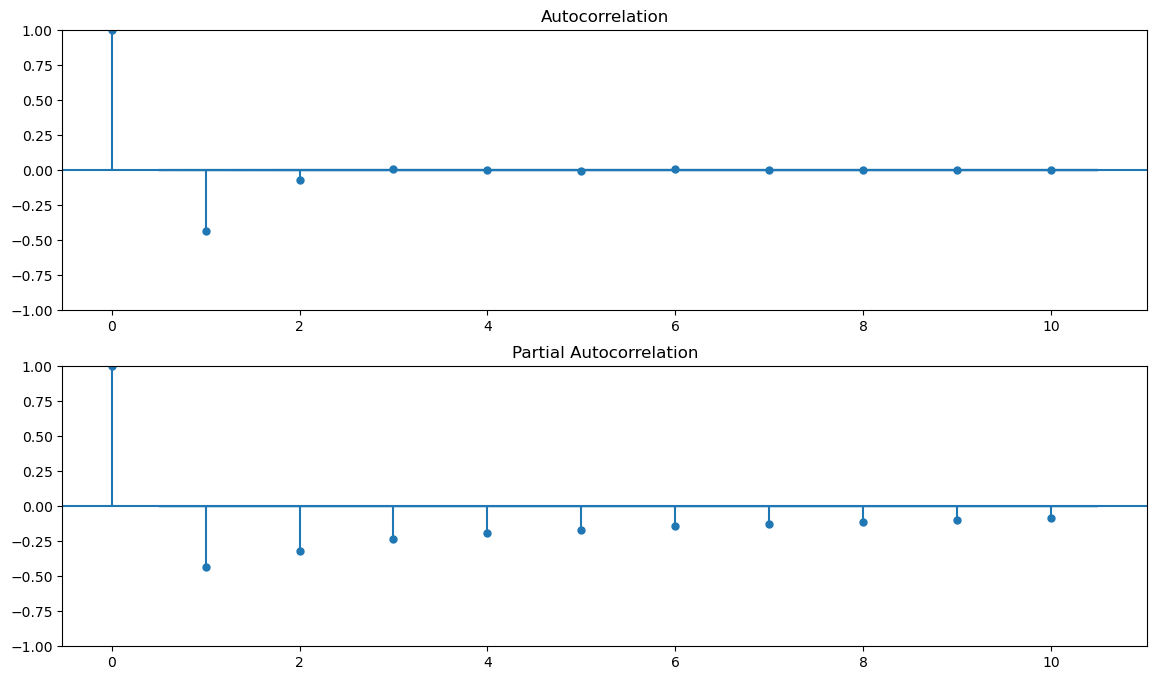

In [4]:
#plotting ACF and PACF
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

#find first difference
change = rain['rain_value'].diff()
change = change.dropna()

# plot the ACF and PACF
fig,axes = plt.subplots(2,1)
plot_acf(change, lags=10, ax=axes[0])
plot_pacf(change,lags=10, ax=axes[1])

plt.show()

There is a clear pattern in ACF and PACF

### 4. Preparing data

In [5]:
rain=rain.drop(columns=['event_timestamp', 'grade', 'interpol_type'])

#resampling the data to the average monthly and annual values
rain_monthly = rain.resample("ME").mean()
rain_annual = rain.resample("YE").mean()

display(rain_annual.head())

,rain_value
Date,
1872-12-31,4.456820
1873-12-31,4.429283
1874-12-31,3.863617
1875-12-31,4.938923
1876-12-31,4.053715


In [6]:
rain_daily = rain.resample("D").mean()
display(rain_daily.head())

,rain_value
Date,
1872-01-03,0.00
1872-01-04,3.81
1872-01-05,2.03
1872-01-06,NaN
1872-01-07,NaN


In [7]:
#counting missing values
print(rain_daily.isna().sum())

#df = rain_daily.fillna(method = 'bfill')
df = rain_daily.bfill()

#df_m = rain_monthly.fillna(method = 'bfill')
df = rain_daily.bfill()

rain_value    14277
dtype: int64


### 5. Rolling window

<Axes: xlabel='Date'>

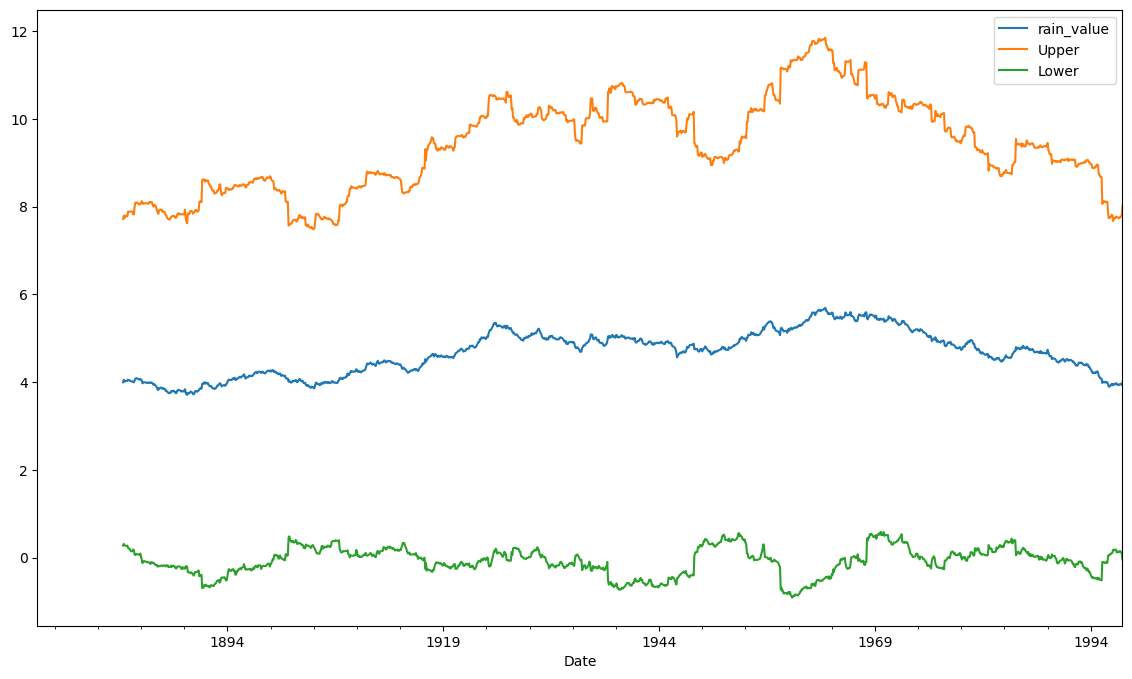

In [8]:
df_mean = rain_monthly.rolling(window=120).mean()
df_std = rain_monthly.rolling(window=120).std()

df_mean['Upper'] = df_mean['rain_value'] + (df_std['rain_value']*2)
df_mean['Lower'] = df_mean['rain_value'] - (df_std['rain_value']*2)


df_mean.plot()

In [9]:
#detrending data
df = df_mean - df_mean.rolling(120).mean()
df = df.dropna()
#df.plot()

### 6. Data decomposition

To separate our data into three main components: general trend, seasonal variations, and the remaining random residuals, we will use Python's statsmodels library. The four graphs present, from the top,  measured rainfall, data trends, seasonal variations, and data residuals.

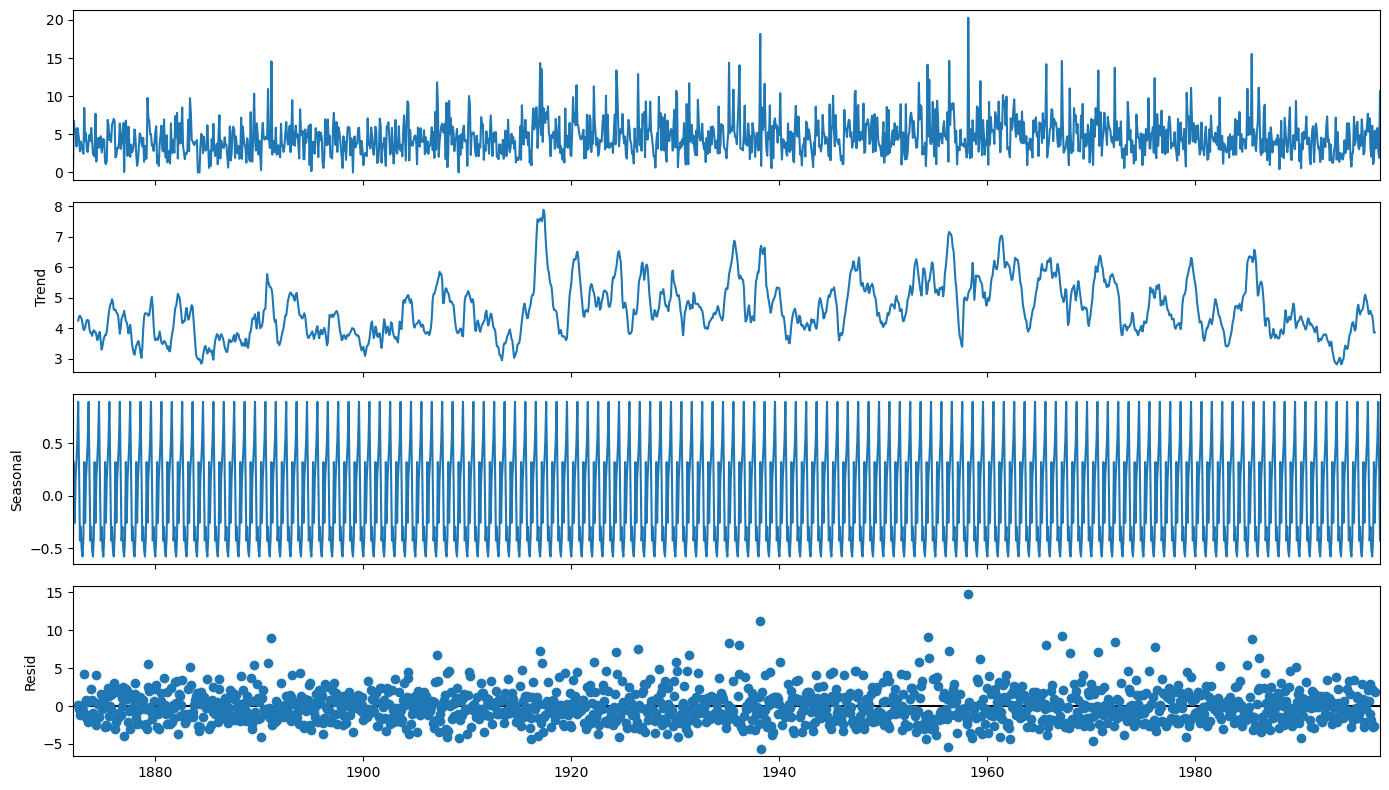

In [10]:
#importing seasonal_decompose module
from statsmodels.tsa.seasonal import seasonal_decompose

seasonal_decompose(rain_monthly).plot();

### 7. Zooming decomposed data

We will plot decomposed data for one ten year interval to examine variations more closely. The graphs clearly show seasonal changes for each year and long term variations. We will explore these changes using autocorrelation and differencing methods.

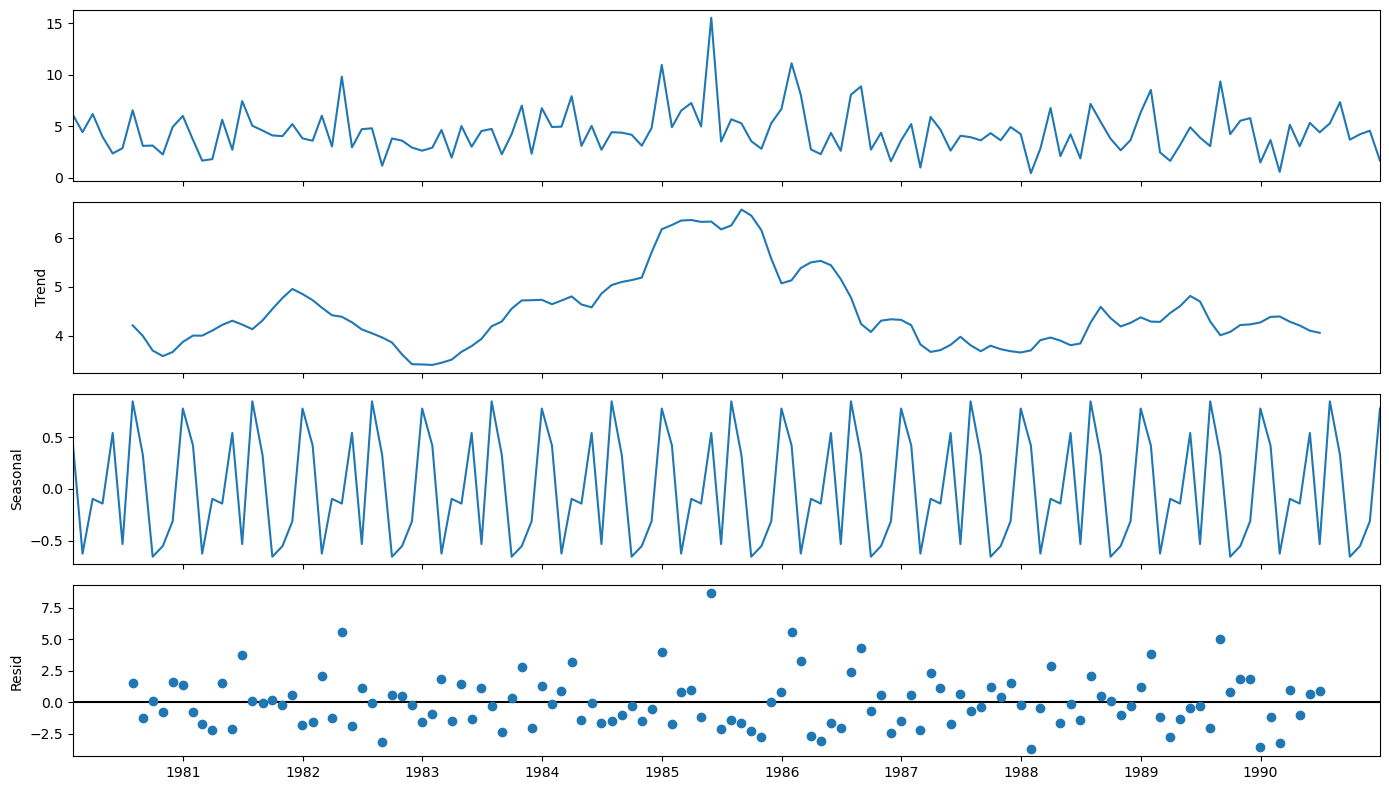

In [11]:
seasonal_decompose(rain_monthly['1980':'1990']).plot();

### 8. Autocorrelation and confidence interval

Autocorrelation is a valuable procedure for time-series data, showing how a variable is correlated to itself. To calculate the autocorrelation,  we will find the relationships between lagged values of time series. For example, we expect that each season, the amount of rain will approximately repeat at equally spaced intervals. Our autocorrelation function (ACF), displays a strong correlation for the months 1,2,3,10,11 and 12 and less significant for other months with the points inside the 95% confidence interval. A gradual drop in values from the maximum to the minimum indicates sesonal changes. 

Text(0, 0.5, 'ACF')

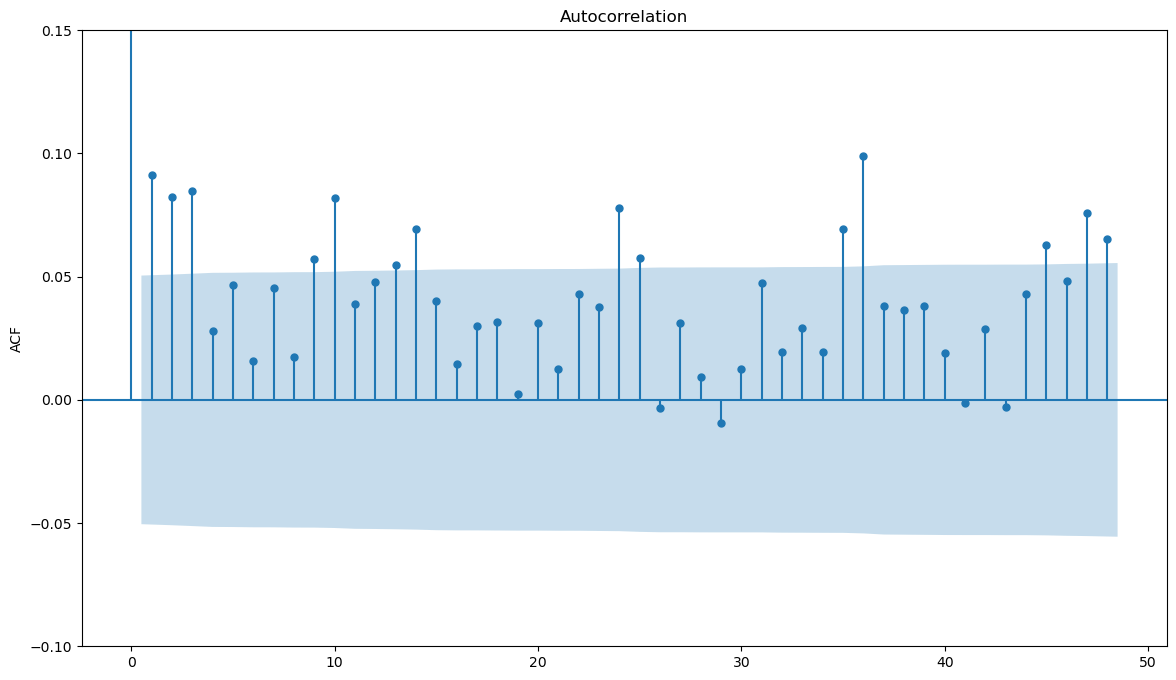

In [12]:
#importing plot_acf
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(rain_monthly.dropna(), lags = 48, alpha=0.05); 
plt.ylim(-0.1,0.15)
plt.ylabel('ACF')

### 9. Autocorrelation and differencing

A stationary time series has properties that do not change with time. By computing the difference between consecutive observations, we can make non-stationary data stationary, and therefore reduce trends and seasonal changes. Also, most popular time-series models require data to be stationary.  After applying differencing and autocorrelation on data, we can notice that all the monthly changes in the rainfall data are random. We are now ready for the time series models. 

            rain_value
Date                  
1872-01-31         NaN
1872-02-29    5.893217
1872-03-31   -1.695195
1872-04-30    0.509101
1872-05-31   -2.222015


<Axes: xlabel='Date'>

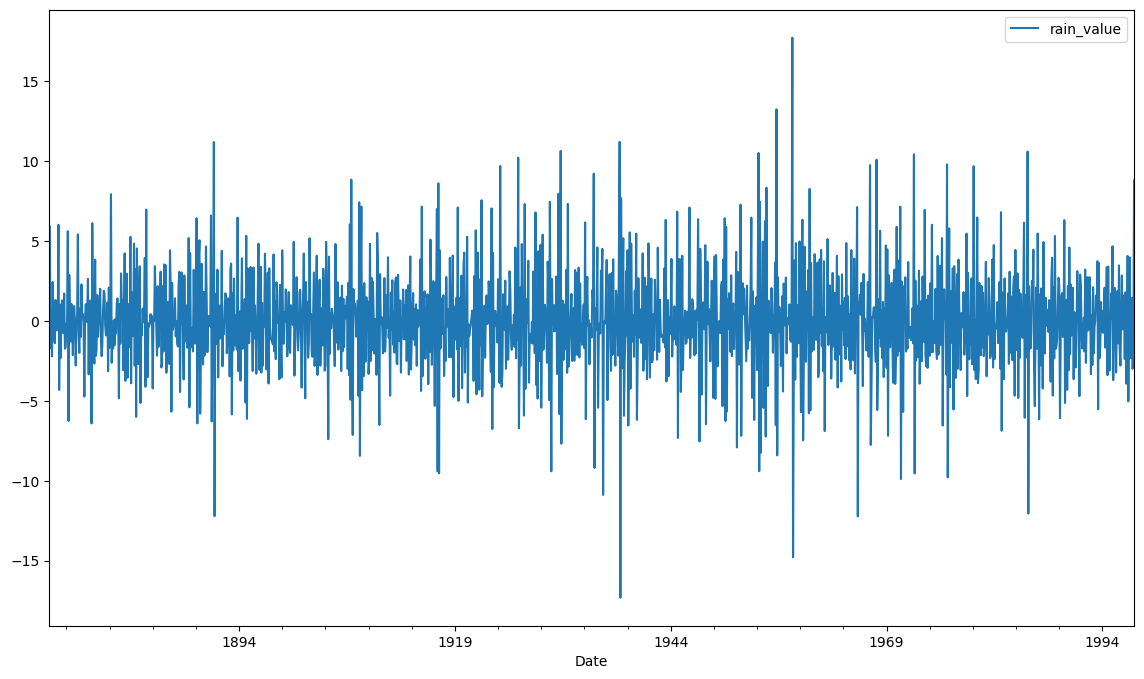

In [13]:
#first-order differencing
rain_monthly_diff = rain_monthly.diff()

print(rain_monthly_diff.head())

rain_monthly_diff.plot()

Text(0, 0.5, 'ACF')

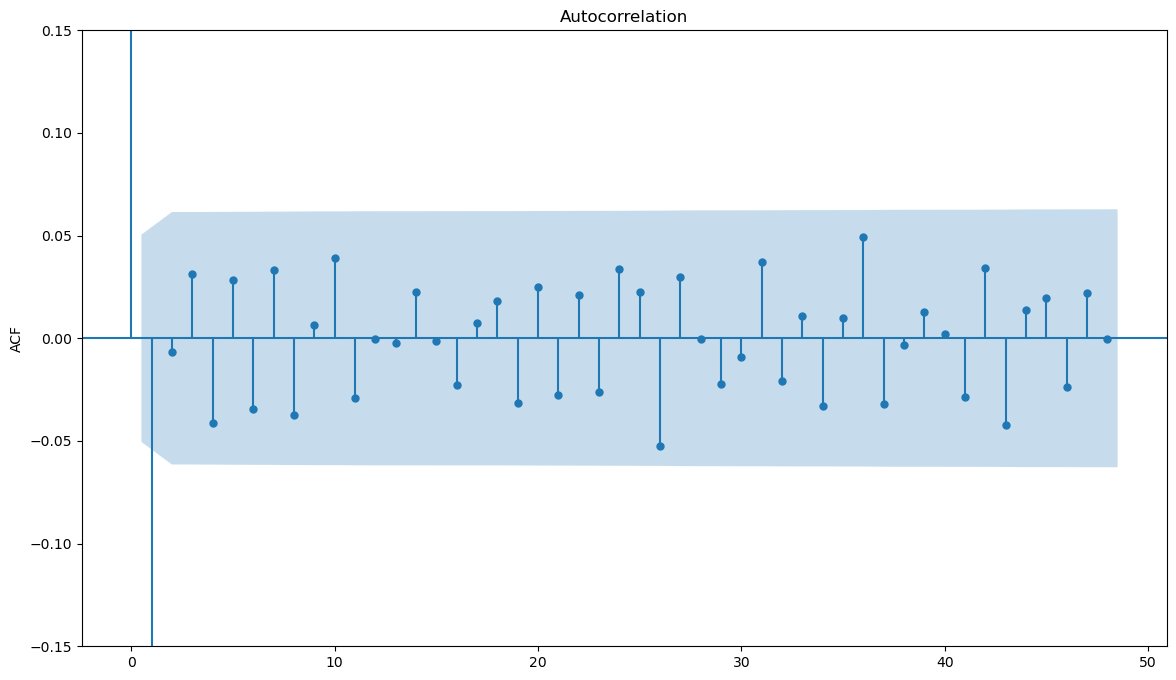

In [14]:
#plotting ACF of monthly differenced values
plot_acf(rain_monthly_diff.dropna(), lags = 48); 
plt.ylim(-0.15,0.15)
plt.ylabel('ACF')

Text(0, 0.5, 'PACF')

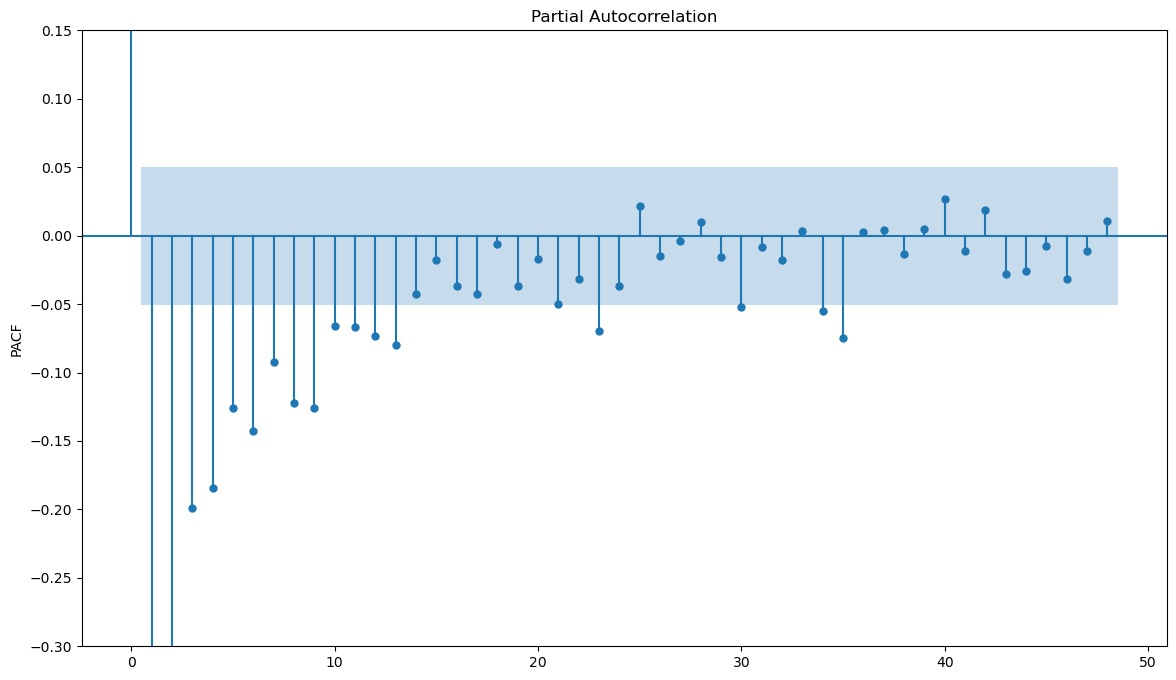

In [15]:
#plotting PACF of monthly differenced values
plot_pacf(rain_monthly_diff.dropna(), lags = 48); 
plt.ylim(-0.30,0.15)
plt.ylabel('PACF')

In [16]:
#approximate confidence interval
import math
a = len(rain_monthly)
conf = 1.96/math.sqrt(a)
print("The approximate confidence interval is +- %4.2f" %(conf))

The approximate confidence interval is +- 0.05


### 10. Fitting SARMAX Model

We will use an extended version of the ARIMA model called SARIMAX(Seasonal Auto-Regressive Integrated Moving Average with eXogenous factors) to understand better the seasonal data. While ARIMA includes an autoregressive integrated moving average component, SARIMAX includes seasonal effects. 

In [17]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(rain.values, order = (2,0,1), seasonal_order = (1,0,1,12),  trend = 'c')
rainfit = model.fit()
print(rainfit.summary())

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                31652
Model:             SARIMAX(2, 0, 1)x(1, 0, 1, 12)   Log Likelihood             -114766.250
Date:                            Mon, 12 Jan 2026   AIC                         229546.500
Time:                                    21:37:42   BIC                         229605.038
Sample:                                         0   HQIC                        229565.235
                                          - 31652                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      2.8422      9.988      0.285      0.776     -16.734      22.418
ar.L1         -0.7627      0.102   

In [18]:
#mean absolute error

residuals = rainfit.resid
print(np.mean(np.abs(residuals)))

5.319819979955468


In [19]:
#rainfit.plot_diagnostics()

#For an ideal model the residuals should be uncorrelated white Gaussian noise centered on zero

In [20]:
sample_prediction = rainfit.get_prediction(start=-25)
mean_sample_pred = sample_prediction.predicted_mean

#confidence interval
confidence_rain = sample_prediction.conf_int()